# **Overview**

The goal of this exercise is to extend the single image encoding paradigms presented in Bricman et al. 2018 and Sitzmann et al. 2020, to jointly encode N images using a neural network (NN). I will begin with Sitzmann et al's code implementing their sinusoidal representation network (SIREN) for a single image, and attempt to extend it to encoding N images simultaneously.

## Simultaneous encoding

One possible way of doing that is to concat all the images into one long image, and use the single image method on it, then sepatrate the represantations. However, this has several issues:
1. This changes the proportions of the image, which may have unforeseen implications, among other things since the pixel coordinates are transformed to the [0,1] range for both axes.
2. Since SIREN learns representations not only for the image values but also for its derivatives, even when they are not used in the loss function (see Figure 1 in the paper), boundaries between images will cause unwanted artifacts.

The first issue may be addressed if we take N to be the square of some natural number, in which case we can order the images in a square and keep the proportions, but this still doesn't help with the second issue.

A second possible way of getting the network to learn N images at once is to treat the set of images as a batch, so that for each pixel location there'll be N training examples, as in regular ML training sets. This method also has a few issues:
1. This will mean that for each pixel location there will be multiple possible outputs, which makes it impossible to find a one-to-one representation. It may be possible to bypass this by adding another feature that will break the degeneracy.
2. It is unclear if the network will be able to learn represenations for the derivatives, as for the single image case, which appears to be an important aspect of SIREN.

A third possibility is to stack the images on top of each other, creating a 3d image, and using the full 3d coordinate as the input. Possible issues for this case are:
1. The network is likely to be influenced by derivatives in the z-axis, which is of course unwanted behaviour since the images are not related to each other. Perhaps it is possible to force the network to ignore these derivatives, but given the simple structure of the network it is unclear to me how that can be done without significantly changing the network.

## Generalization

I believe that the reference to generalization here refers to section 4.4 of Sitzmann et al. - learning priors over the space of functions, which can be used to reconstruct images from sparse input (inpainting). It is possible that upscaling can also be considered a way for testing generalization, since the images are no longer tied into their pixel representations, but have a continuous represtentation based only on location and derivatives. Both can be tracked during training by plotting an output of the network at that step for a higher resolution coordinate input (for the upscaling case) or for a partial grid (for the inpainting case).

## Image interpolation

Sitzmann et al. offer a way to interpolate two images using SIREN by training it using a composite of the two images' gradients as the target. However, in this case we've already learned representations of both images at once, so it may be possible to use the network directly to fuse them.

Specifically, if using the gradients as inputs for the model, it is possible that some linear combination of the representations of the two images can give the intended result.

As far as similarity measures, this is something I have little experience with, but it seems that there are many such measures being used. I would guess that a useful measure for this case would be one that looks more at the underlying structure than a pixel-by-pixel comparison. As such, cosine similarity and other such methods will probably be less useful here.

# **Importing the SIREN network**

## Imports and definitions

Let us first define the network as done in Sitzmann et al's colab notebook.

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

In [5]:
# We start by loading images for the 48x48 resolution

size = 48
img_dir = './drive/MyDrive/Jobs/Cognitv/Data/{}/'.format(size)
# img_dir = './Data/{}/'.format(size)

image_names = os.listdir(img_dir)

In [6]:
# Some helpful functions defined in Sitzmann et al's colab notebook
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

# Derivatives
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

# A function that gets a flattened tensor for a single image
def get_img_tensor(img_dir, img_name, sidelength):
    img = Image.fromarray((plt.imread(img_dir + img_name) * 255).astype(np.uint8))
    transform = Compose([
        Resize(sidelength,3),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)[:3,:,:]
    return img

In [7]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

## Test code on an image from our dataset

In their example notebook, the authors use a greyscale image. Here we use color images, so the dimensionality is different. Let us first change the code and make sure we can run the model on a single color image.

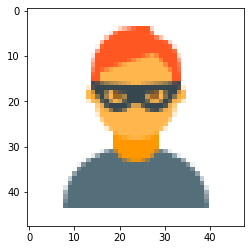

In [8]:
# Plot to make sure we're reading the images in correctly

init_img = plt.imread(img_dir + image_names[0])
img_tensor = init_img[:,:,:3] # Removing the transparency layer
img = Image.fromarray((init_img * 255).astype(np.uint8))
plt.imshow(img)

In [9]:
# Changed to handle RGB images

class ImageFitting():
    def __init__(self, img_dir, img, sidelength):
        super().__init__()
        img = get_img_tensor(img_dir, img, sidelength)
        self.pixels = img.permute(1, 2, 0).contiguous().view(-1, 3)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Step 0, Total loss 0.723670


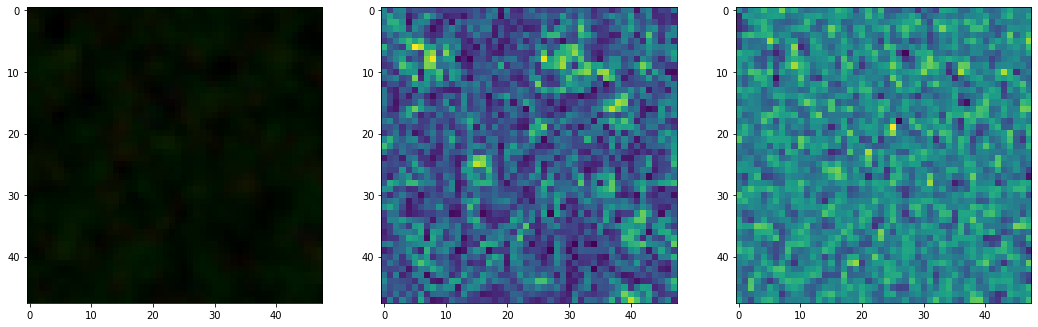

Step 10, Total loss 0.332603


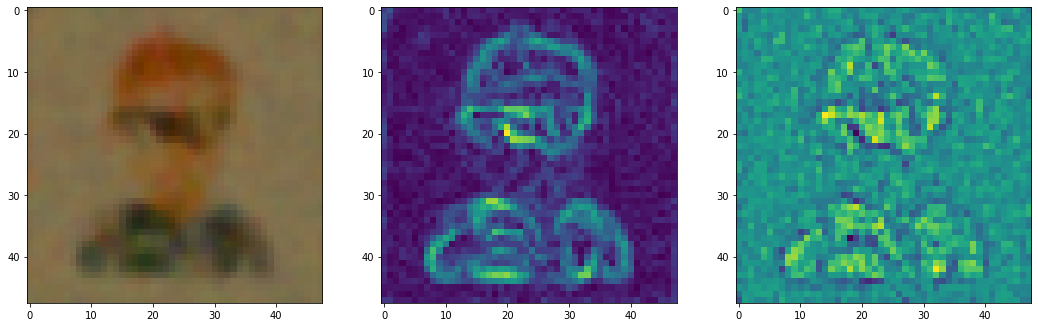

Step 20, Total loss 0.146134


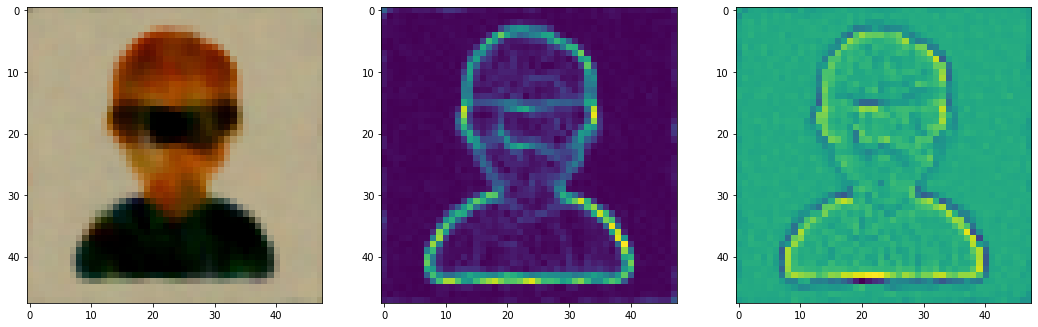

Step 30, Total loss 0.049923


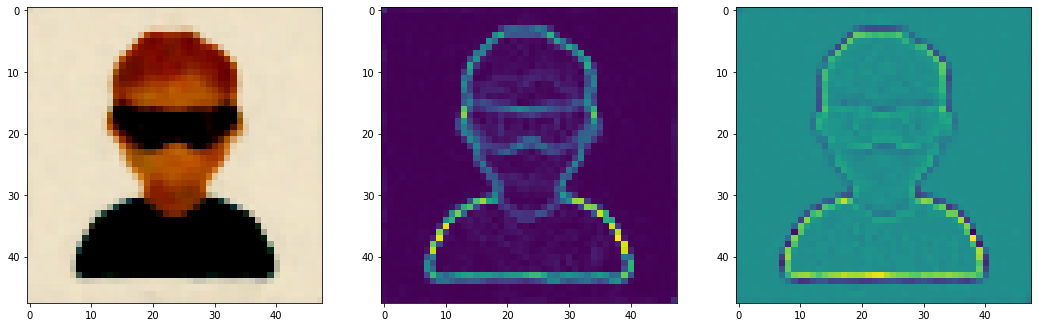

Step 40, Total loss 0.023792


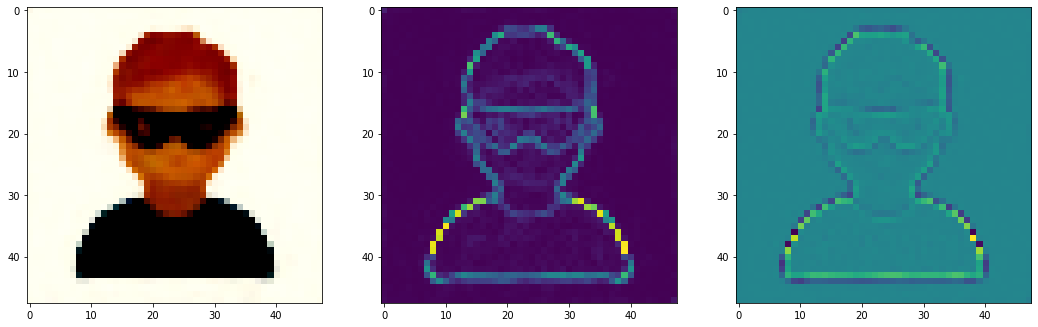

Step 50, Total loss 0.015448


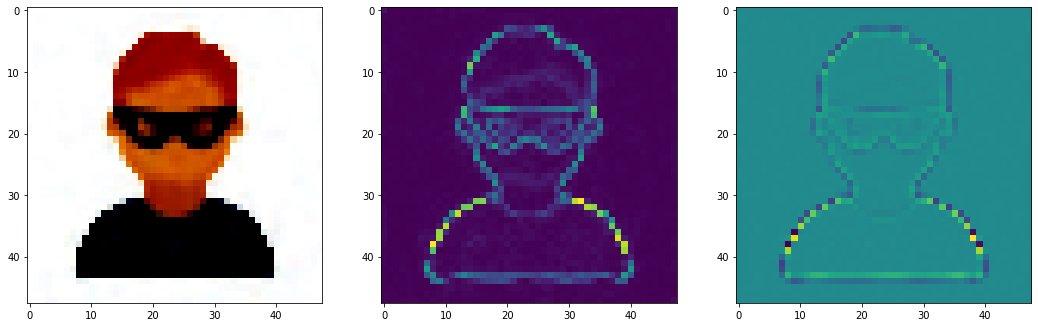

Step 60, Total loss 0.010446


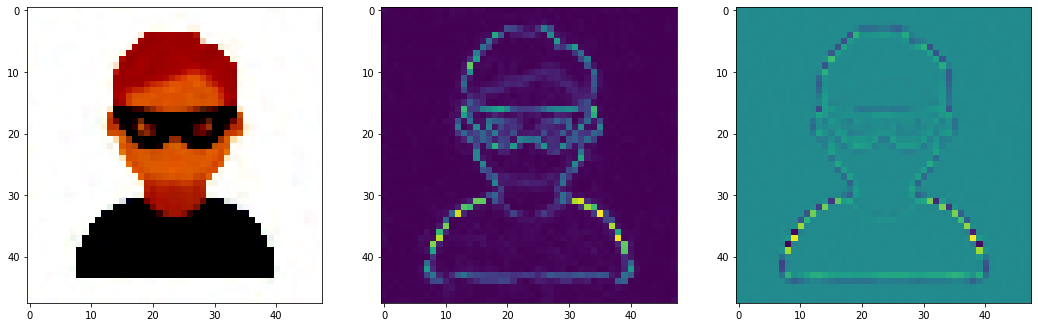

Step 70, Total loss 0.007130


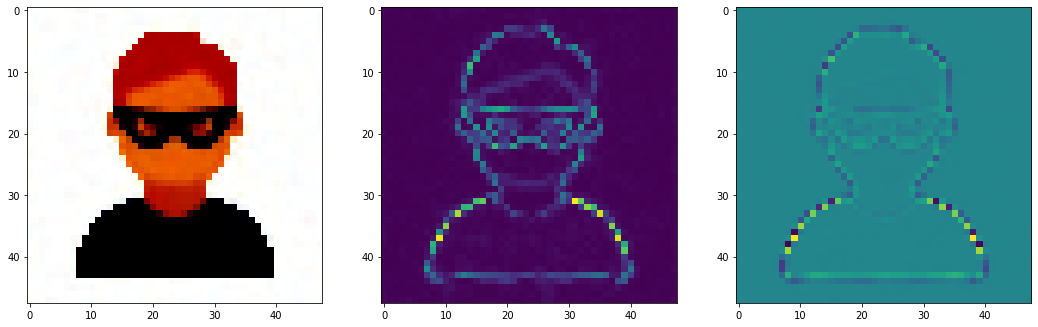

Step 80, Total loss 0.004966


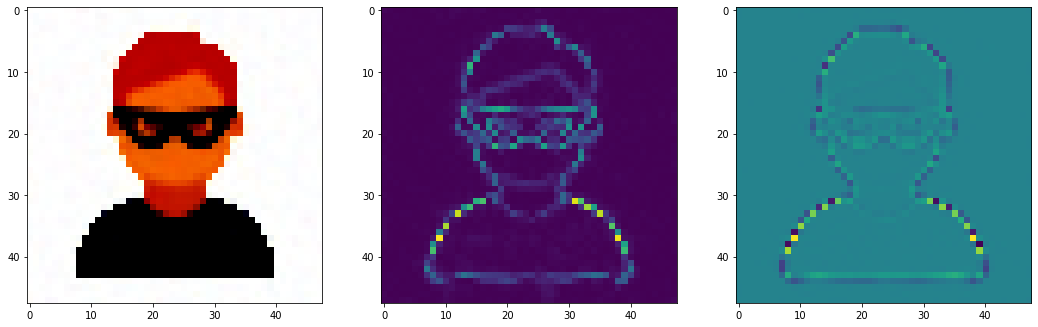

Step 90, Total loss 0.003527


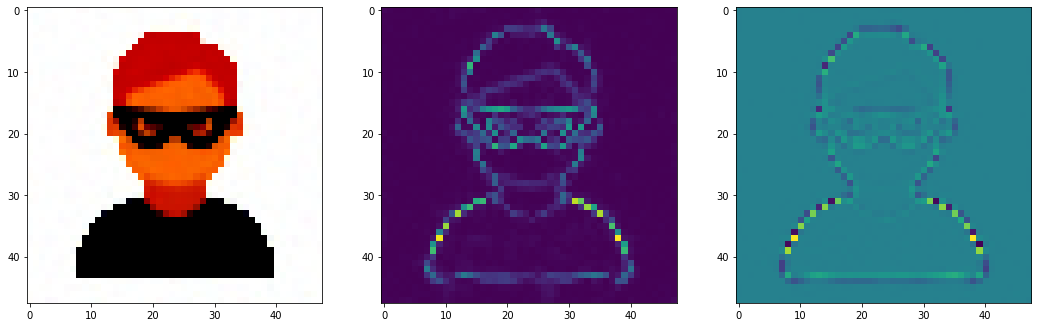

Step 100, Total loss 0.002566


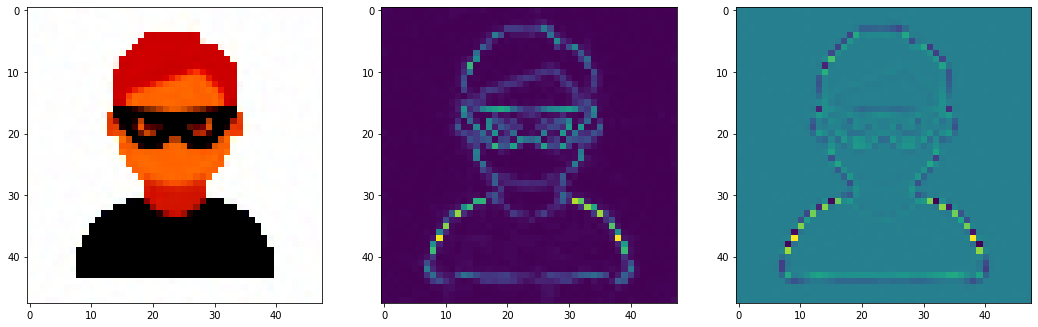

Step 110, Total loss 0.001909


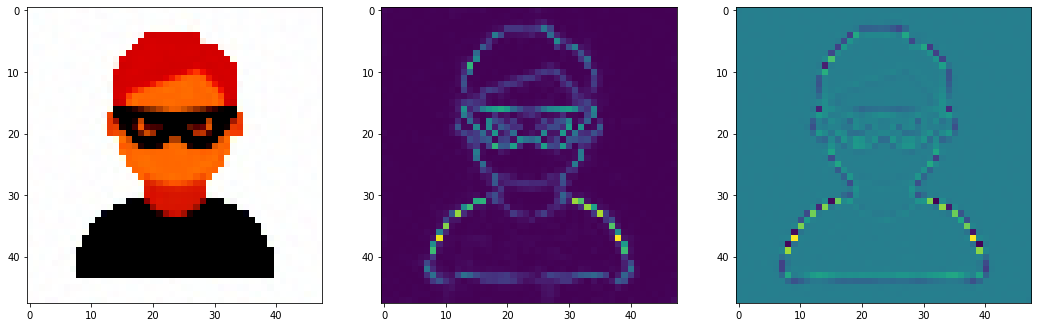

Step 120, Total loss 0.001449


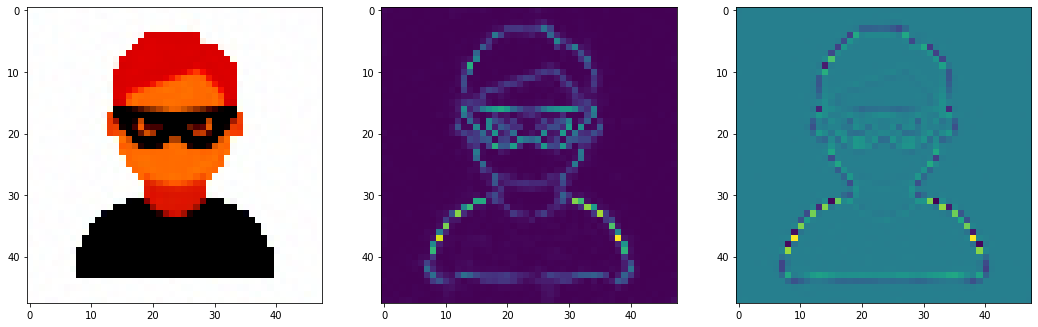

Step 130, Total loss 0.001119


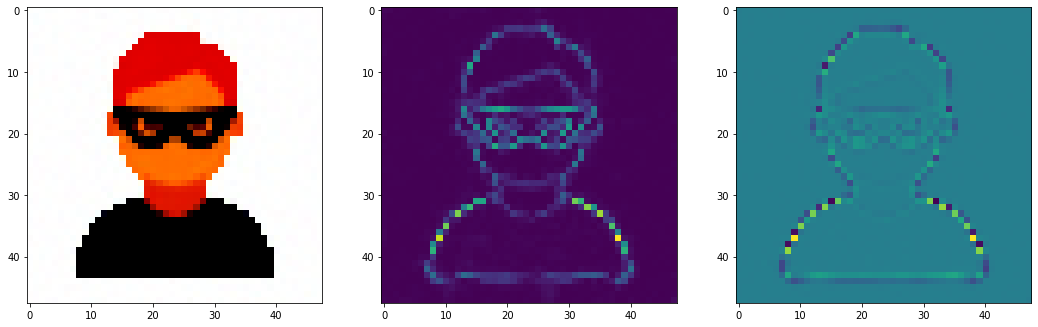

Step 140, Total loss 0.000877


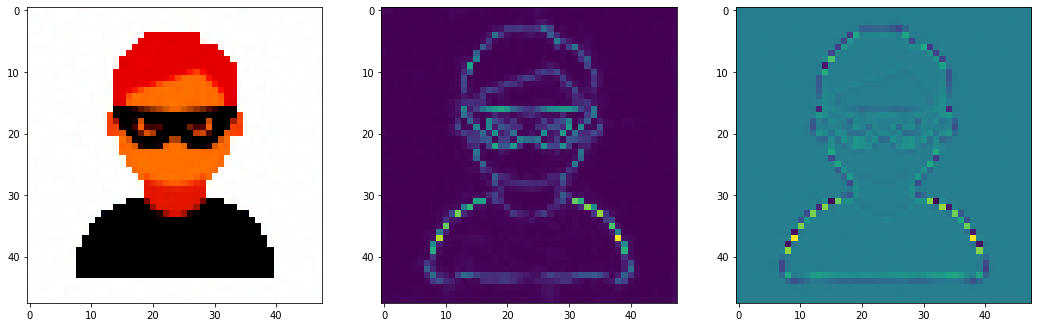

Step 150, Total loss 0.000696


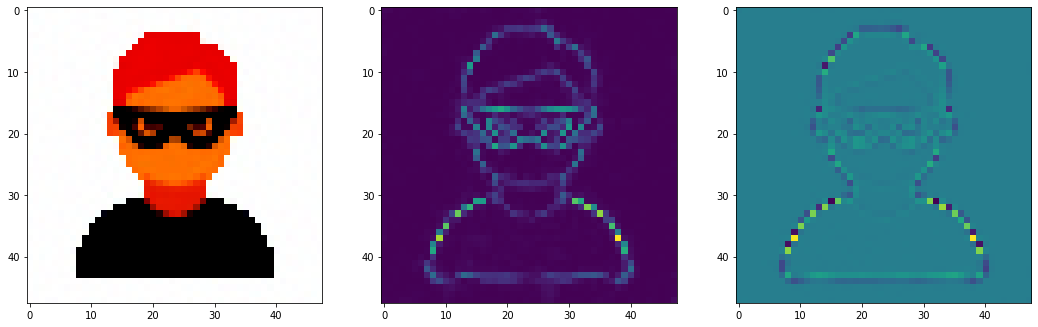

Step 160, Total loss 0.000560


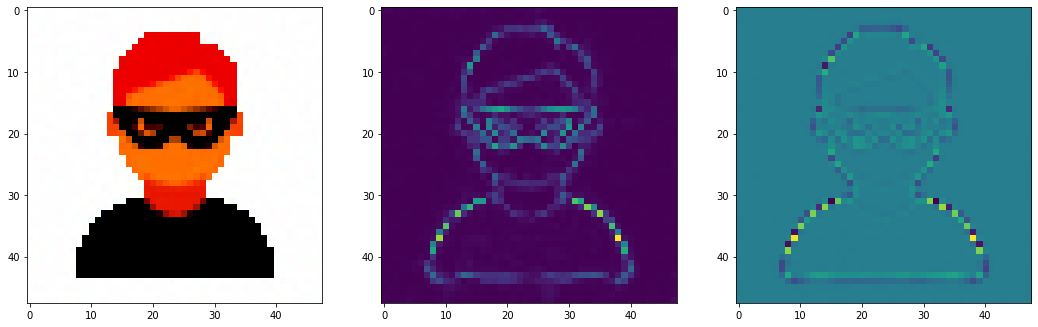

Step 170, Total loss 0.000458


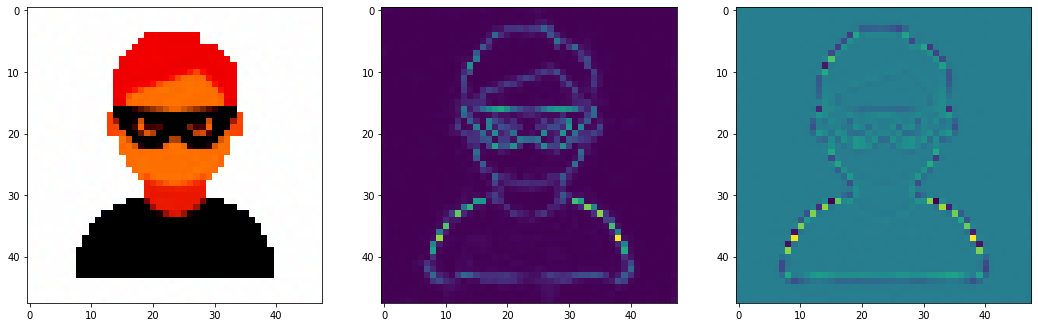

Step 180, Total loss 0.000380


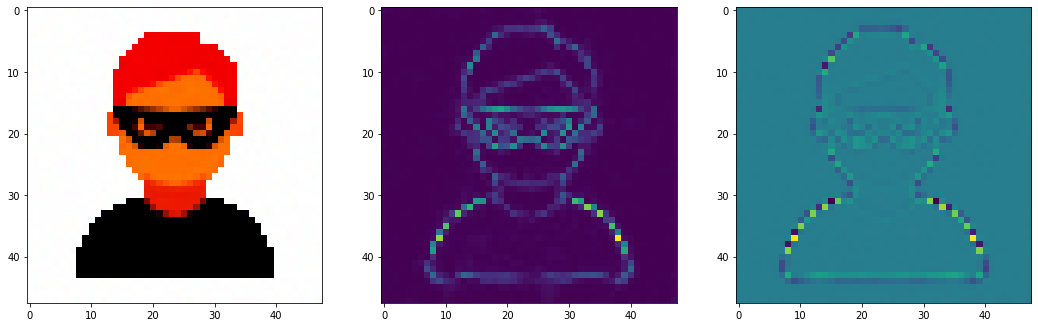

Step 190, Total loss 0.000319


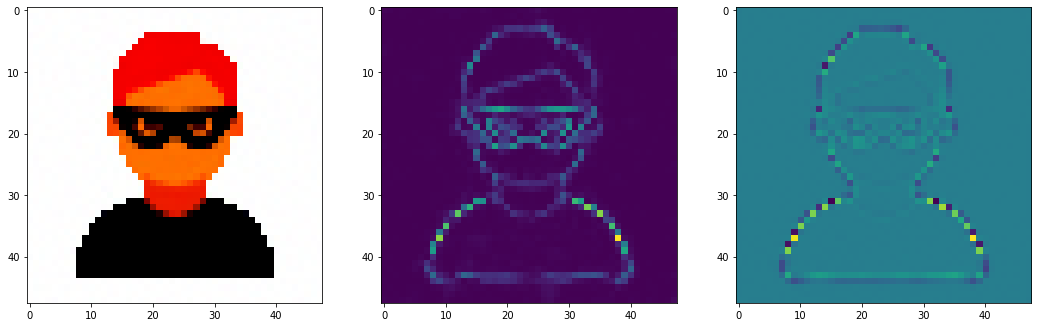

Step 200, Total loss 0.000272


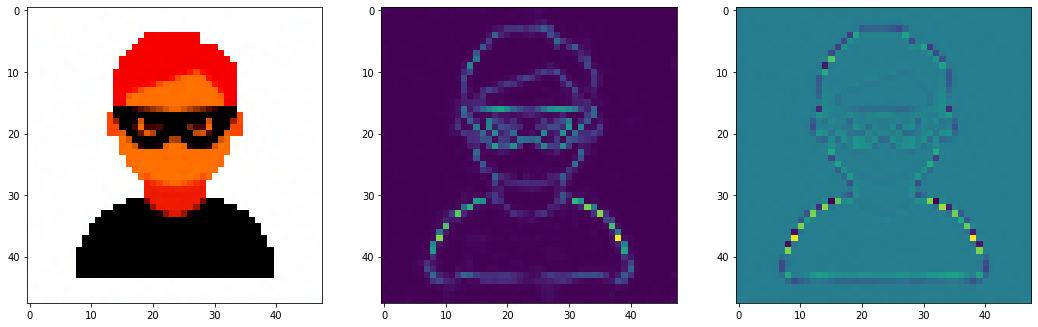

Step 210, Total loss 0.000233


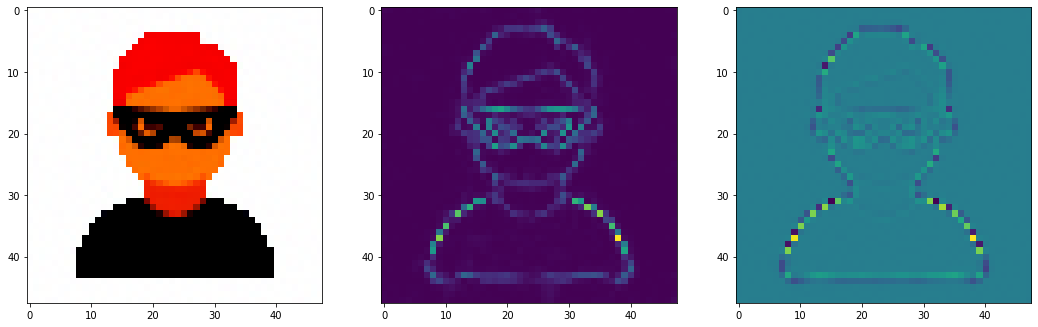

Step 220, Total loss 0.000202


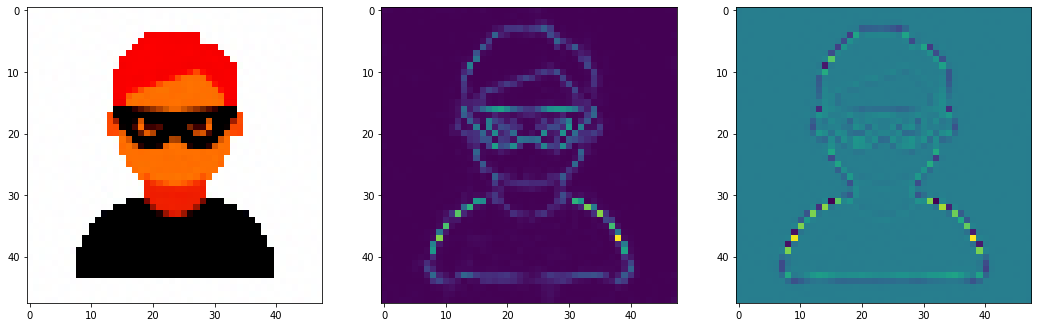

Step 230, Total loss 0.000176


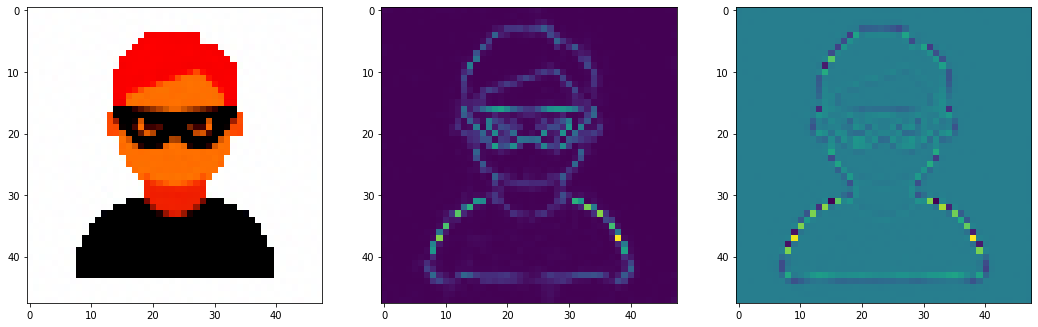

Step 240, Total loss 0.000154


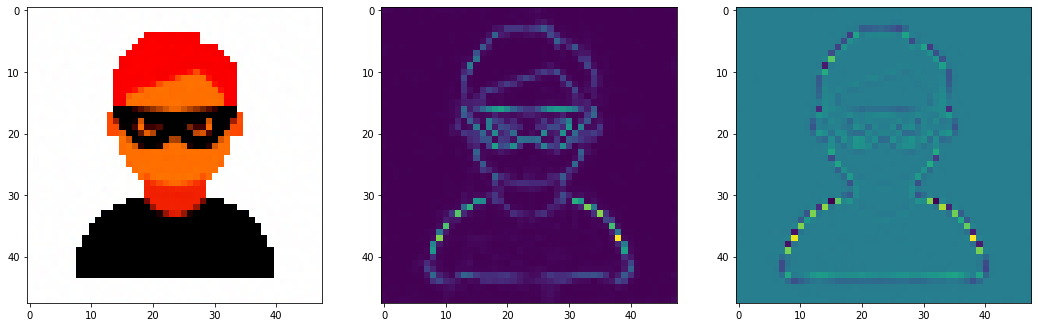

Step 250, Total loss 0.000136


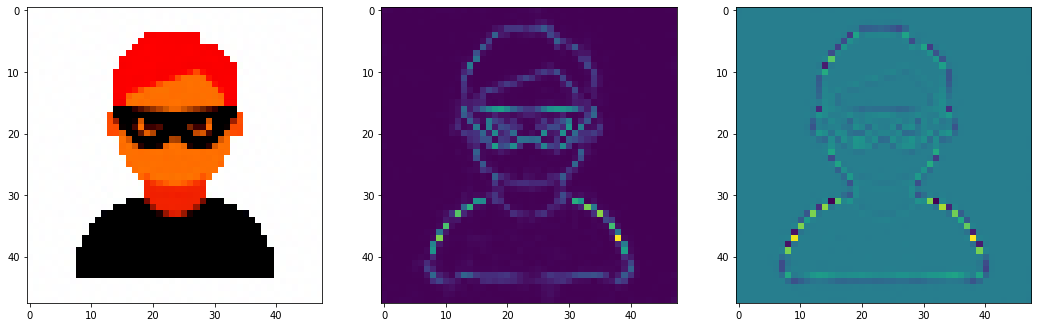

Step 260, Total loss 0.000120


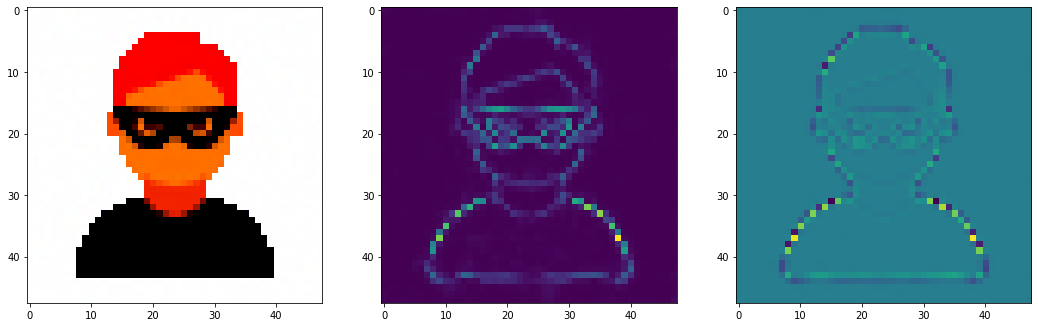

Step 270, Total loss 0.000107


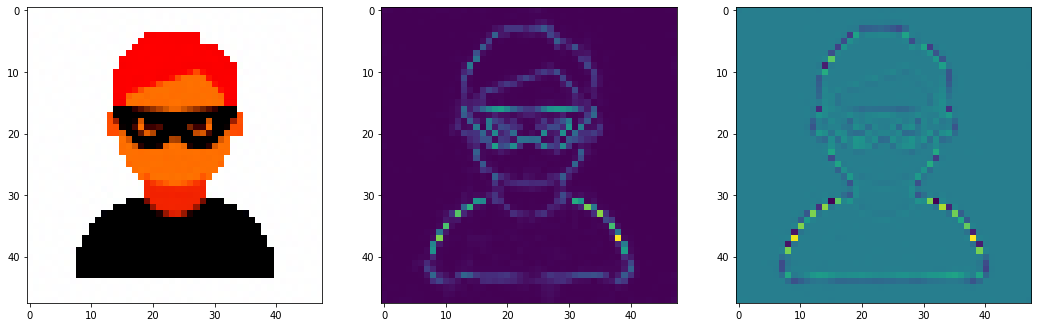

Step 280, Total loss 0.000095


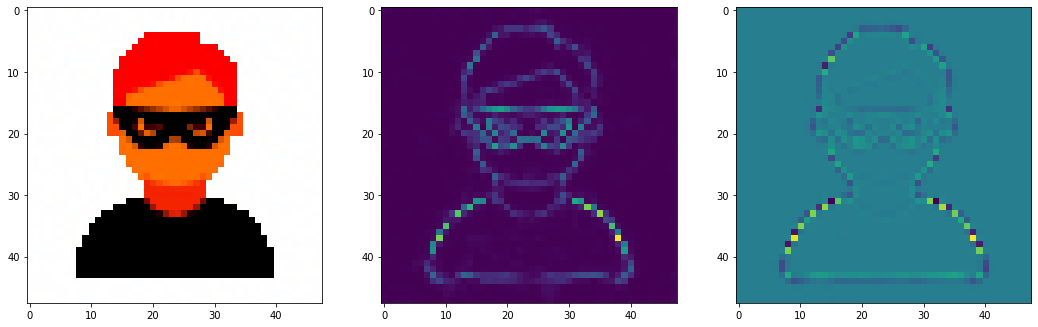

Step 290, Total loss 0.000085


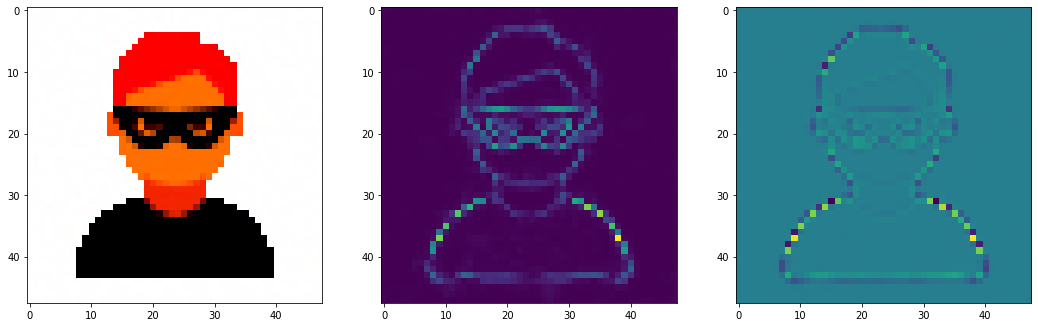

Step 300, Total loss 0.000076


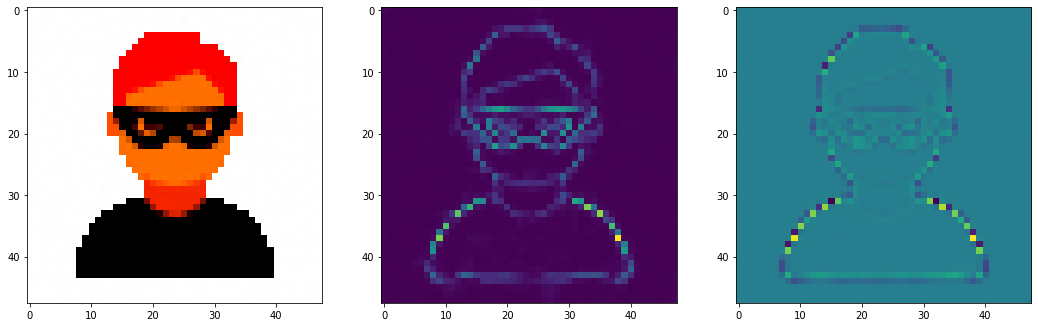

Step 310, Total loss 0.000068


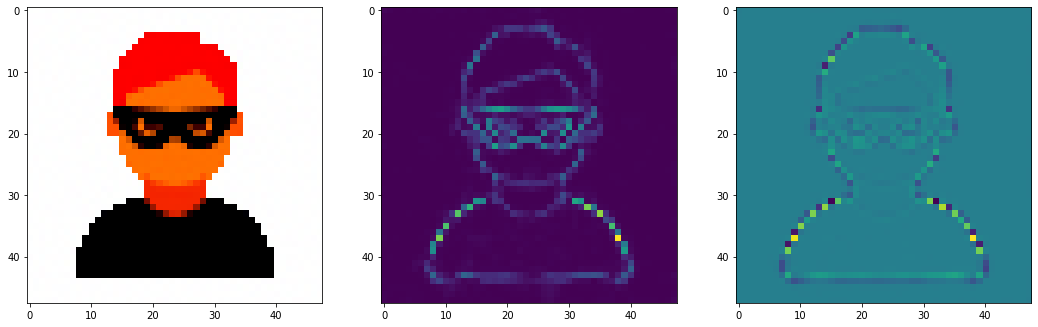

Step 320, Total loss 0.000061


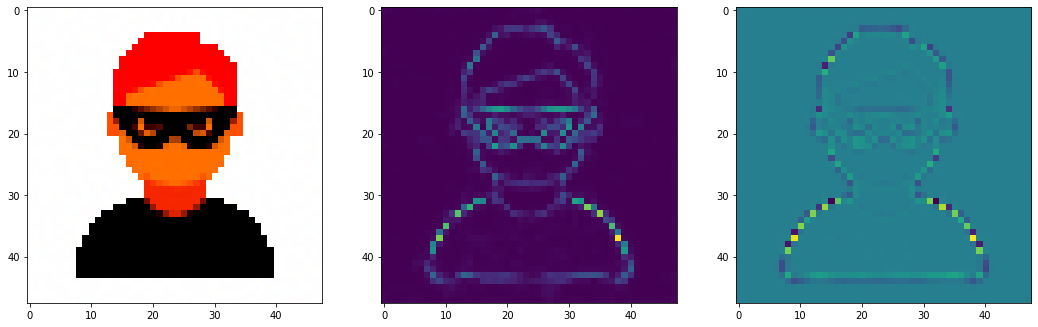

Step 330, Total loss 0.000055


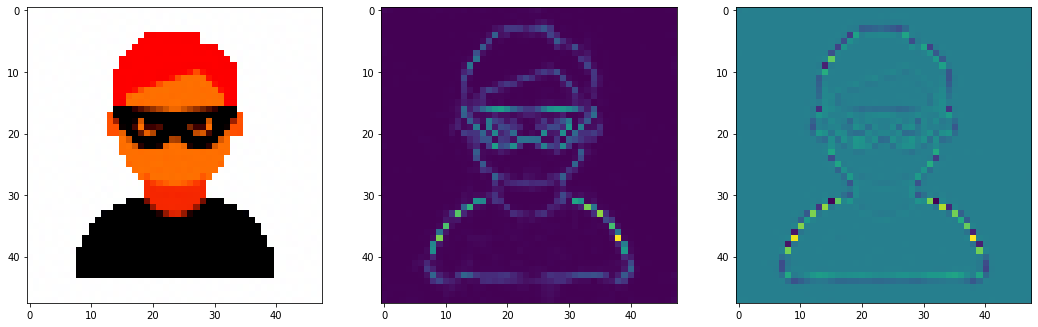

Step 340, Total loss 0.000049


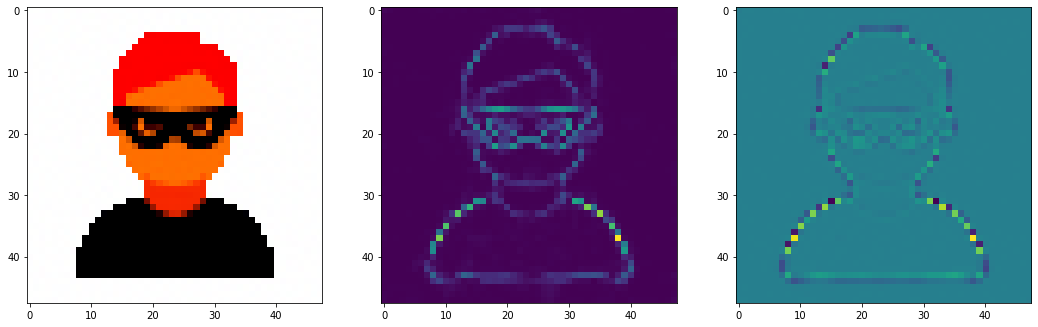

Step 350, Total loss 0.000044


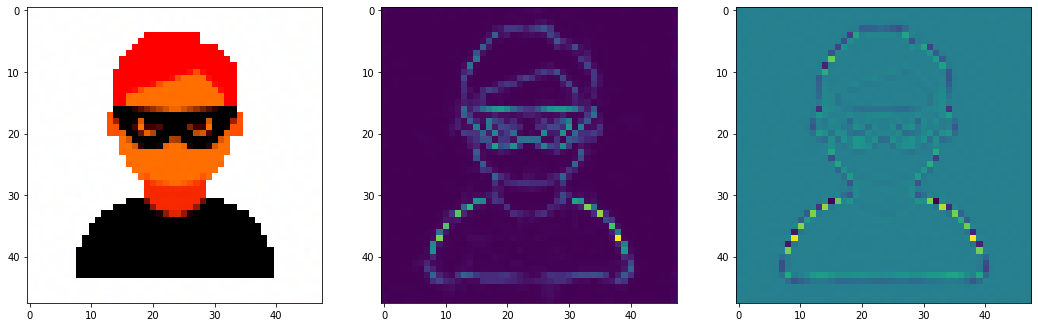

Step 360, Total loss 0.000040


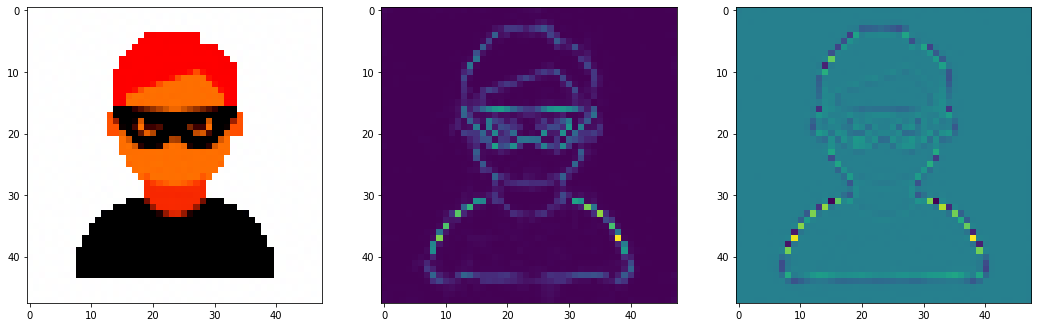

Step 370, Total loss 0.000036


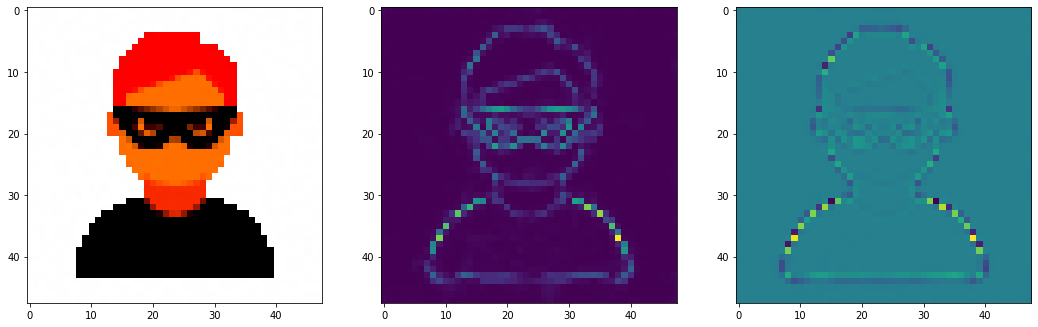

Step 380, Total loss 0.000032


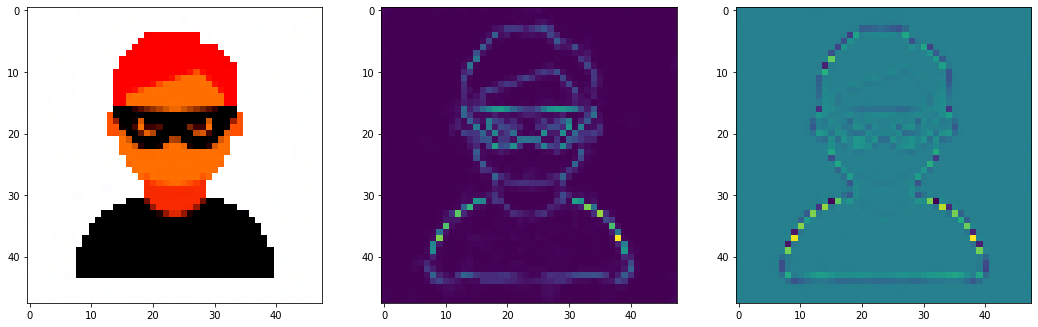

Step 390, Total loss 0.000029


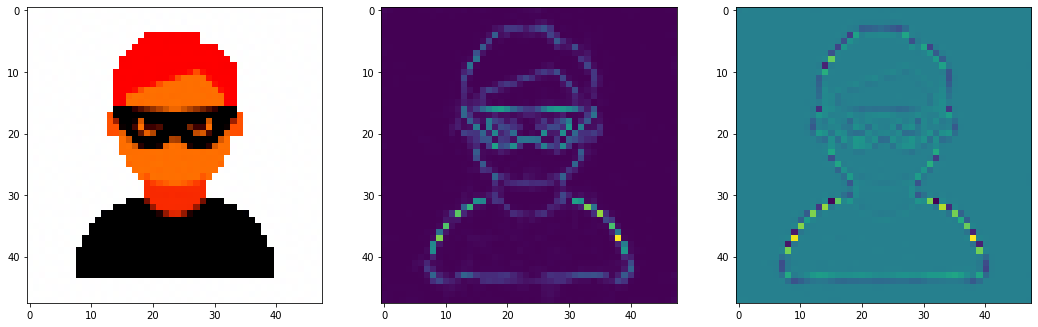

Step 400, Total loss 0.000026


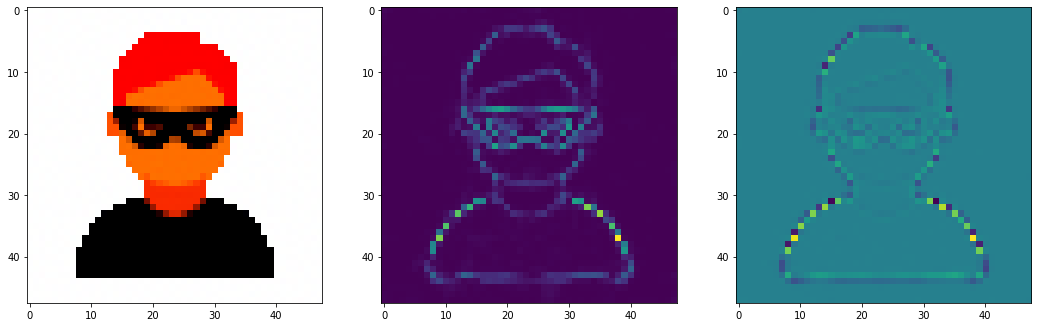

Step 410, Total loss 0.000023


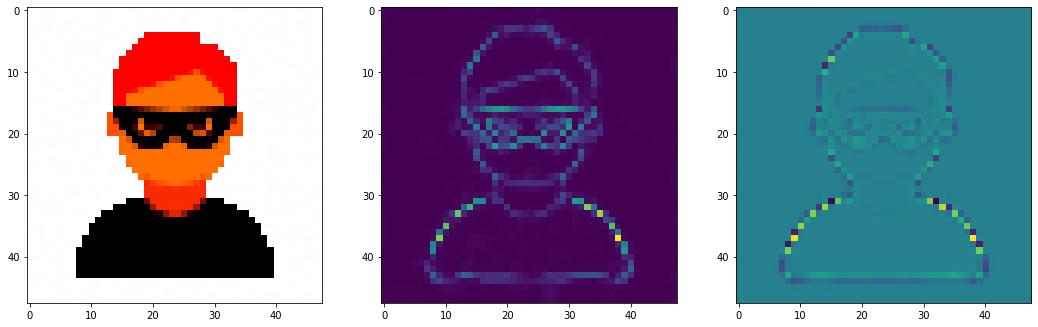

Step 420, Total loss 0.000021


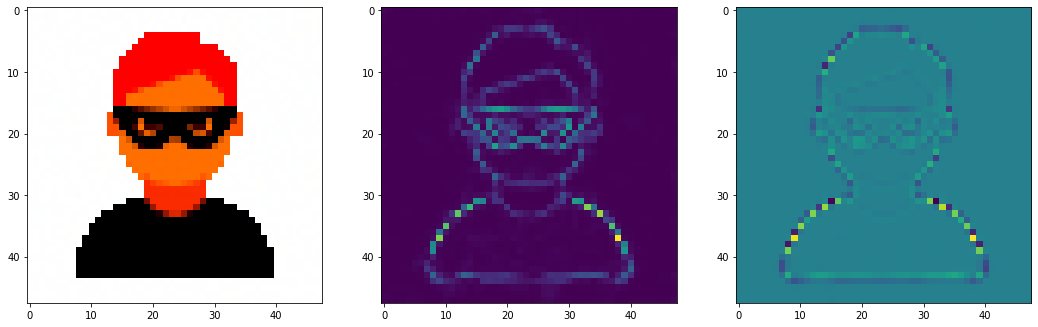

Step 430, Total loss 0.000019


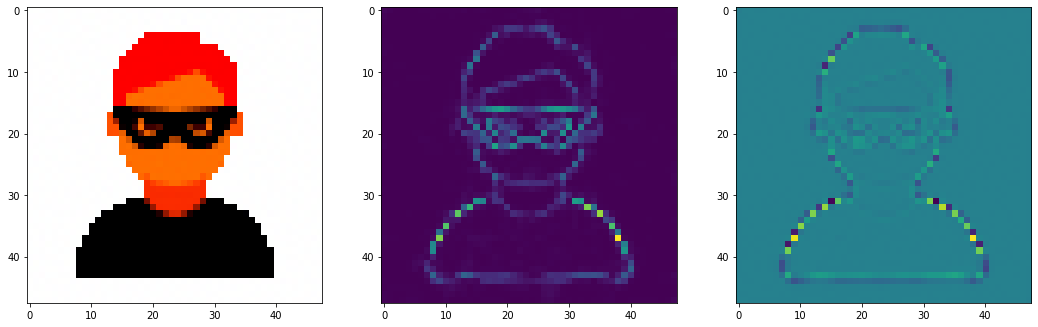

Step 440, Total loss 0.000017


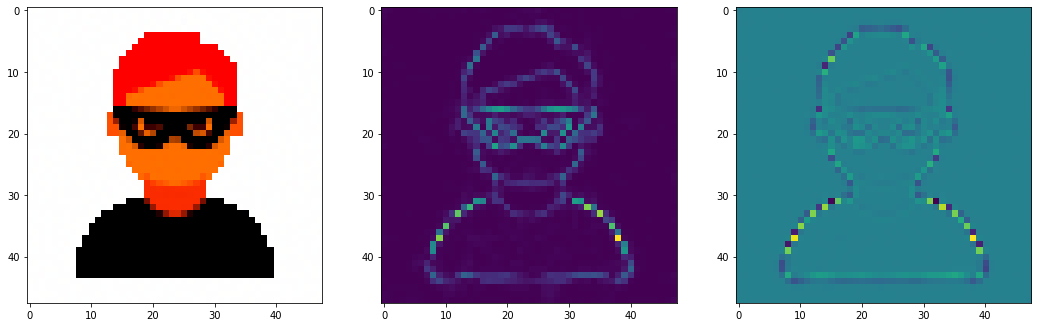

Step 450, Total loss 0.000015


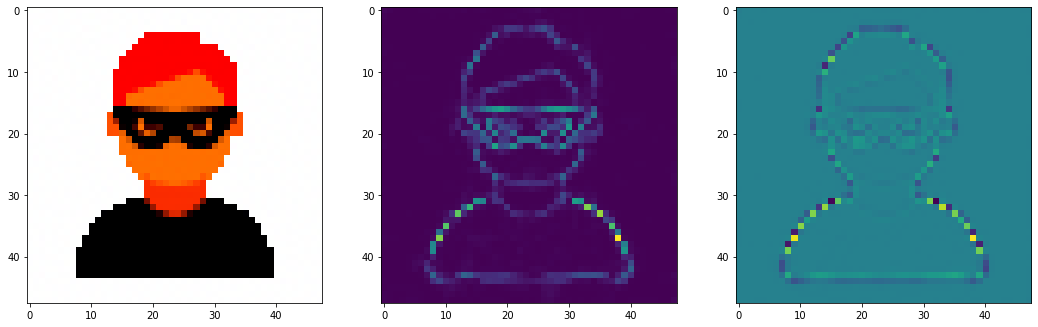

Step 460, Total loss 0.000014


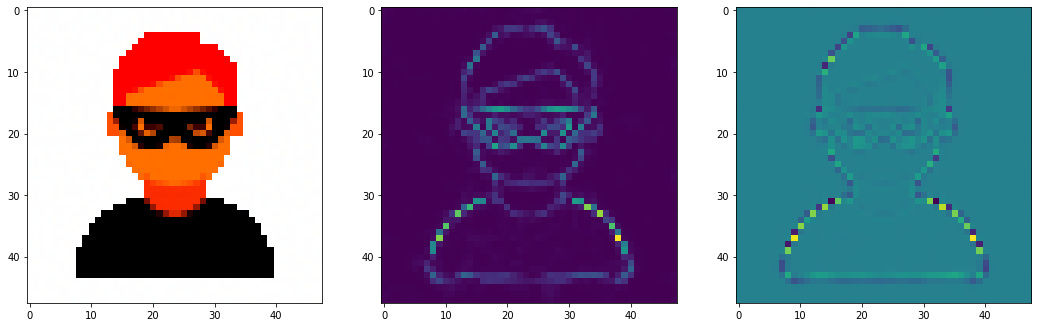

Step 470, Total loss 0.000012


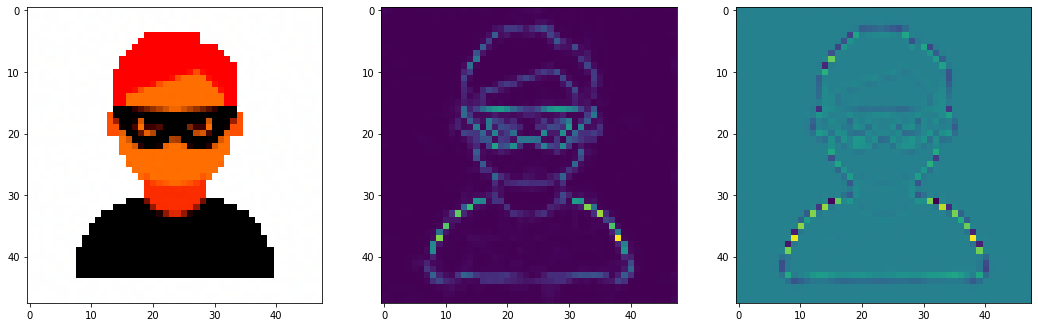

Step 480, Total loss 0.000011


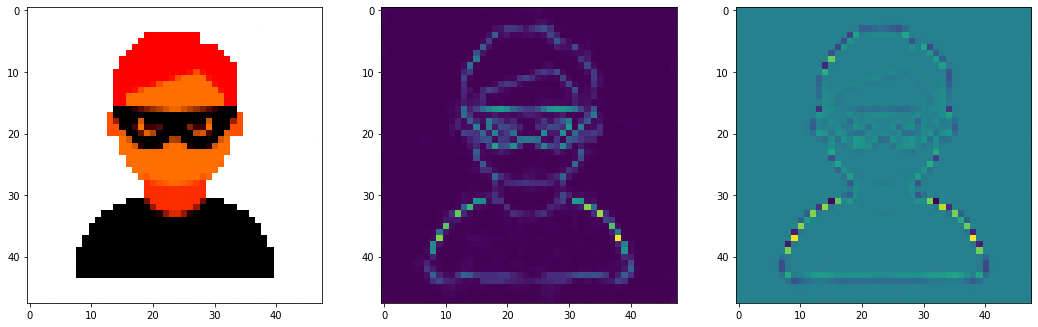

Step 490, Total loss 0.000010


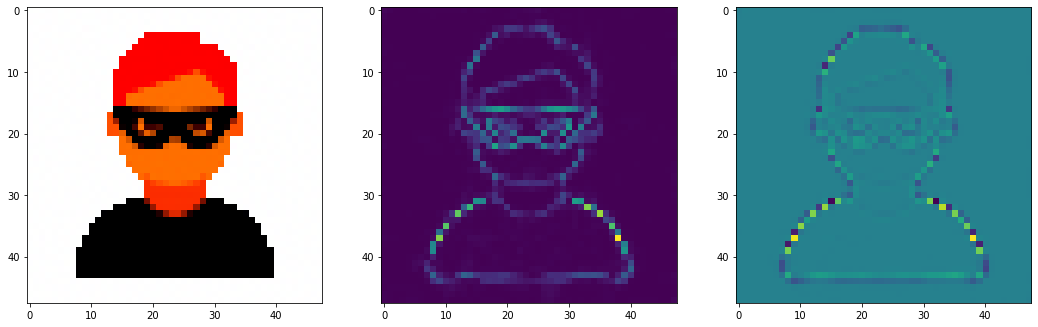

In [10]:
# The code directly from the paper's notebook

img = ImageFitting(img_dir, image_names[0], size)
dataloader = DataLoader(img, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=3, hidden_features=255, 
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(size,size,3).detach().numpy())
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(size,size).detach().numpy())
        axes[2].imshow(img_laplacian.cpu().view(size,size).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

The colors seem a bit off, it seems that the ImageFitting function somehow distorts them a bit.

## Image upscaling

Let's test how upscaling works for this.

In [12]:
# with torch.no_grad():
#   input_grid = get_mgrid(size*2)  
#   up_image, coords = img_siren(input_grid)
#   plt.imshow(up_image.view(size*2,size*2,3).detach().numpy())

This worked at some point and then stopped working. I could not figure out why.

# **Encoding multiple images**

From the options listed above, the second option seems the most viable, so I'll start with it. This means turning each pixel into a batch of N pixels of that location taken from the different images.

## Reading the data

I will work with 5 images as a proof of concept.

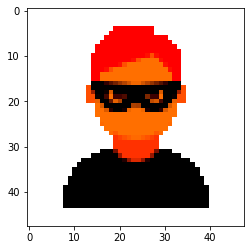

In [13]:
# Plotting to make sure we read the images in correctly

N = 5

images = torch.empty([3, size, size, N])
for i in range(N):
  images[:,:,:,i] = get_img_tensor(img_dir, image_names[i], size)

plt.imshow(images[:,:,:,0].permute(1, 2, 0))

In [14]:
# A function that will help us compare visually between real images and images produced by the model
def plot_compare(real_images, size, output_images = None, N=5):
  fig, axes = plt.subplots(2,N, figsize=(5*N,5))

  for i in range(N):
    axes[0,i].imshow(real_images[0][1][i*size**2: (i+1)*size**2, :].cpu().view(size,size,3).detach().numpy())
    if output_images is not None:
      axes[1,i].imshow(output_images[:, i*size**2: (i+1)*size**2, :].cpu().view(size,size,3).detach().numpy())

In [15]:
class MultiImageFitting():
    def __init__(self, img_dir, sidelength, N = None):
        super().__init__()
        image_names = os.listdir(img_dir)
        if N is None:
          N = len(image_names)
        images = torch.empty([3, sidelength, sidelength, N])
        for i in range(N):
          images[:,:,:,i] = get_img_tensor(img_dir, image_names[i], size)
        self.pixels = images.permute(3, 1, 2, 0).contiguous().view(-1, 3)
        self.coords = torch.cat([get_mgrid(sidelength, 2) for i in range(N)])

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

Step 0, Total loss 0.709602
Step 10, Total loss 0.427970
Step 20, Total loss 0.327078
Step 30, Total loss 0.286337
Step 40, Total loss 0.275434
Step 50, Total loss 0.272715
Step 60, Total loss 0.271460
Step 70, Total loss 0.270616
Step 80, Total loss 0.270037
Step 90, Total loss 0.269614
Step 100, Total loss 0.269300
Step 110, Total loss 0.269068
Step 120, Total loss 0.268895
Step 130, Total loss 0.268763
Step 140, Total loss 0.268660
Step 150, Total loss 0.268578
Step 160, Total loss 0.268511
Step 170, Total loss 0.268457
Step 180, Total loss 0.268411
Step 190, Total loss 0.268374
Step 200, Total loss 0.268342
Step 210, Total loss 0.268315
Step 220, Total loss 0.268292
Step 230, Total loss 0.268273
Step 240, Total loss 0.268256
Step 250, Total loss 0.268242
Step 260, Total loss 0.268230
Step 270, Total loss 0.268220
Step 280, Total loss 0.268211
Step 290, Total loss 0.268203
Step 300, Total loss 0.268197
Step 310, Total loss 0.268191
Step 320, Total loss 0.268186
Step 330, Total loss 

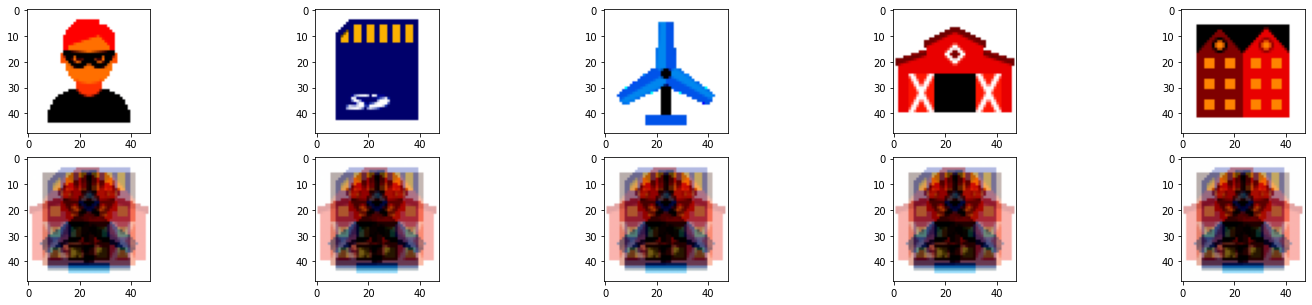

In [16]:
imgs = MultiImageFitting(img_dir, size, N = N)
dataloader = DataLoader(imgs, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=3, hidden_features=255, 
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        # fig, axes = plt.subplots(1,3, figsize=(18,6))
        # axes[0].imshow(model_output.cpu().view(size,size,3).detach().numpy())
        # axes[1].imshow(img_grad.norm(dim=-1).cpu().view(size,size).detach().numpy())
        # axes[2].imshow(img_laplacian.cpu().view(size,size).detach().numpy())
        # plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

plot_compare(imgs, size, model_output, N = N)

As expected, without another input that can break the degenracy, the network simply learns a combination of all the images, repeated for all images.

# **Breaking the degeneracy**

Since we know that the derivatives are important for the network's ability to learn, and since they should, for the most part, be different between images, we can add the gradients of each RGB channel as inputs and see if that helps us towards our goal.

I was unable to use the PyTorch derivative functions defined above for this, so I used numpy's gradient function. To use this I had to rewrite the code to retrieve and handle 3d arrays, and only then flatten them and create tensors out of them.

In [17]:
def get_mgrid3d(sidelen, dim=2):
    '''A '''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen, requires_grad=True)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

def get_img_tensor3d(img_dir, img_name, sidelength):
    img = Image.fromarray((plt.imread(img_dir + img_name) * 255).astype(np.uint8))
    transform = Compose([
        Resize(sidelength,3),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)[:3,:,:]
    return img

class MultiImageFittingWithDerivatives():
    def __init__(self, img_dir, sidelength, N = None):
        super().__init__()
        image_names = os.listdir(img_dir)
        if N is None:
          N = len(image_names)

        coords = torch.tensor(get_mgrid3d(sidelength, 2).detach().numpy(), requires_grad=True)
        inputs = []
        pixels = []

        for i in range(N):
          image = get_img_tensor3d(img_dir, image_names[i], sidelength)
          pixels.append(image.permute(1, 2, 0).contiguous().view(-1, 3))
          grad = np.empty([6, size, size])
          for i in range(3):
            grad[i*2:(i+1)*2, :, :] = np.gradient(image[i])
          grad = torch.tensor(grad)
          inputs.append(torch.cat((coords, grad.reshape(-1,6)), 1))
          
        self.inputs = torch.cat(inputs).float()
        self.pixels = torch.cat(pixels).float()

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.inputs, self.pixels

Step 0, Total loss 0.740709
Step 10, Total loss 0.512815
Step 20, Total loss 0.440584
Step 30, Total loss 0.386025
Step 40, Total loss 0.345874
Step 50, Total loss 0.315273
Step 60, Total loss 0.292404
Step 70, Total loss 0.274911
Step 80, Total loss 0.260974
Step 90, Total loss 0.249705
Step 100, Total loss 0.241675
Step 110, Total loss 0.234420
Step 120, Total loss 0.228914
Step 130, Total loss 0.223852
Step 140, Total loss 0.220714
Step 150, Total loss 0.216272
Step 160, Total loss 0.212513
Step 170, Total loss 0.211640
Step 180, Total loss 0.207501
Step 190, Total loss 0.203994
Step 200, Total loss 0.201702
Step 210, Total loss 0.198615
Step 220, Total loss 0.196058
Step 230, Total loss 0.193960
Step 240, Total loss 0.192056
Step 250, Total loss 0.189846
Step 260, Total loss 0.188138
Step 270, Total loss 0.186449
Step 280, Total loss 0.184771
Step 290, Total loss 0.184447
Step 300, Total loss 0.182912
Step 310, Total loss 0.182073
Step 320, Total loss 0.180319
Step 330, Total loss 

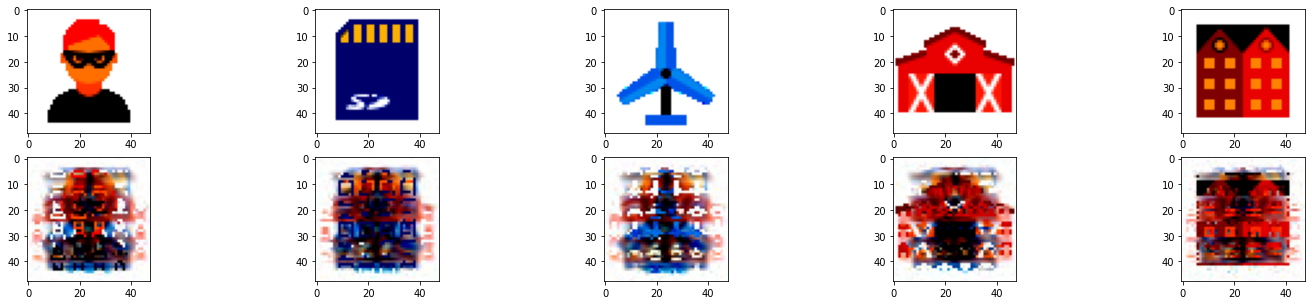

In [18]:
imgs = MultiImageFittingWithDerivatives(img_dir, size, N = N)
dataloader = DataLoader(imgs, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=8, out_features=3, hidden_features=128, 
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

    optim.zero_grad()
    loss.backward()
    optim.step()


plot_compare(imgs, size, model_output, N = N)

There is definite improvement, but this is still far from the results we see for single images. It is possible that adding the laplacian of each RGB channel will help further break the degeneracy and improve the separation of the images.

# **Conclusions and thoughts**

I've had many techincal issues that I was unable to overcome within the time I had, most of them probably stemming from lack of familiarity with PyTorch.
Among other things, when trying to run the code on all images I run out of memory, which is probably due to the fact that I'm taking the entire dataset as one input, as is done in the original notebook. It will probably make sense to make each pixel an example and then run it in batches.

Given more time and PyTorch control, I'd have liked to implement the following in order to improve results and get better understanding and results:
1. Investigate the color changes that stem from the ImageFitting function and see if it's possible to fix them.
2. Add the laplacian as an input. This can probably help significantly to break the degeneracy between images.
3. Add a visual tracking of the convergence and generalization of the multi-image network - at choses steps, plot side by side the image produced by the network at that step, an upscaled image for that stpe, and an inpainted image for that step.
4. Play around with network architectures - deeper, larger layers, etc.
5. Implement the change mentioned above, so that pixels are treated as separate examples. This can help with the memory issue and allow some more options.
6. Try using k-fold validation, which may improve the network's ability to perform inpainting.